<a href="https://colab.research.google.com/github/edponce/DoyleInvestigators/blob/master/Project1_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import re
import numpy
import collections
import urllib.request
import urllib.parse
import numpy as np
import seaborn as sns
import pandas
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###$\color{brown}{\rm Corpus~Selection}$

In [ ]:
CORPUS_URL = {
    'The Valley of Fear': "http://www.gutenberg.org/files/3289/3289.txt",
    'A Study of Scarlet': "http://www.gutenberg.org/files/244/244.txt",
    'The Sign of the Four': "http://www.gutenberg.org/files/2097/2097.txt",
    'The Hound of the Baskervilles': "http://www.gutenberg.org/files/2852/2852.txt",
}

###$\color{brown}{\rm Read~Web~Page~Content}$
Read the corpus from web page to start processing. Use text in ASCII format (no BOMs) and remove Windows-based newlines '\r'.

In [ ]:
def get_corpus_from_url(url):
    with urllib.request.urlopen(url) as fd:
        text = fd.read()
        try:
            return text.decode('utf-8')
        except UnicodeDecodeError:
            return text.decode('iso-8859-1')


def get_corpus_from_file(file):
    with open(file) as fd:
        return fd.read()


def get_corpus(key):
    def validate_url(url):
        parsed_url = urllib.parse.urlparse(url)
        return all([parsed_url.scheme, parsed_url.netloc, parsed_url.path])

    # Check if a filename was provided
    if os.path.isfile(key):
        return get_corpus_from_file(key)
    else:
        if key in CORPUS_URL:
            file = os.path.basename(CORPUS_URL[key])
            if os.path.isfile(file):
                return get_corpus_from_file(file)

    # Check if a URL was provided
    if validate_url(key):
        return get_corpus_from_url(key)
    else:
        if key in CORPUS_URL:
            url = CORPUS_URL[key]
            if validate_url(url):
                return get_corpus_from_url(url)

    raise Exception(f"corpus '{key}' not found")

###$\color{brown}{\rm Split~into~Parts~and~Chapters}$
CORE METHODS.

In [ ]:
def get_gutenberg_start_tag(text):
    """Find Gutenberg's start tag (and producer, if available).

    Notes:
        * re.match() searches at the beginning of strings, but there are
          certain character combinations that are not considered strings,
          and thus need to use re.search(), even if it is at the beginning
          of line. An example are the asterisks in the Gutenberg START
          tag.
    """
    return re.search(
        r'\s*\r?\n'  # pre-whitespace
        r'\*{3}\s*'  # 3 asterisks
        r'start[^\r\n]+'  # tag text
        r'\s*\*{3}'  # 3 asterisks
        r'\r?\n\s*'  # post-whitespace
        r'(produced by.+\r?\n\s*)?',  # producer line with post-whitespace
        text
    )


def get_gutenberg_end_tag(text):
    """Find Gutenberg's end tag (and transcriber's notes, if available).

    Notes:
        * Duplicate/similar Gutenberg end tags.
        * Use a newline before transcriber note to prevent matching similar
          (but indented) notes at beginning of text.
        * Use DOTALL flag to match transcriber's notes across multiple lines.
          But be wary that using DOTALL prevents the use of '.+' for other
          cases, so use '[^\r\n]' instead.
    """
    return re.search(
        r'('
        r'(\s*\r?\noriginal transcriber.+)?'  # transcriber notes with pre-whitespace
        r'\s*\r?\n'  # pre-whitespace
        r'end[^\r\n]+'  # duplicate/similar tag text
        r')?'
        r'\s+'  # pre-whitespace
        r'\*{3}\s*'  # 3 asterisks
        r"end[^\r\n]+"  # tag text
        r'\s*\*{3}'  # 3 asterisks
        r'\r?\n\s*',  # post-whitespace
        text, flags=re.DOTALL
    )


def get_gutenberg_part_labels(text):
    """
    Notes:
        * We consider the start of the text when the first part/chapter starts.
    """
    return list(re.finditer(
        r'\s*\r?\n'  # pre-whitespace
        r'('
        r'part (\d|[ivx])+'  # label with Arabic or Roman numbering
        r'(-+|\.)?'  # label-title delimiter
        r'.*'  # title
        r')'
        r'\r?\n\s*',  # post-whitespace
        text
    ))


def get_gutenberg_chapter_labels(text):
    """
    Notes:
        * Some texts have the chapter tag and title in different lines.
    """
    return list(re.finditer(
        r'\s*'  # pre-whitespace
        r'\r?\n'  # no indentation
        r'('
        r'chapter (\d|[ivx])+'  # label with Arabic or Roman numbering
        r'(-+|\.)?'  # label-title delimiter
        r'(\s{2})?'  # whitespace for titles two line apart
        r'.*'  # title
        r')'
        r'\r?\n\s*',  # post-whitespace
        text
    ))


def get_gutenberg_epilogue_label(text):
    return re.search(
        r'\s*\r?\n'  # pre-whitespace
        r'epilogue'  # tag text
        r'\r?\n\s*',  # post-whitespace
        text
    )


def get_toc(text):
    """Table of contents."""
    pass


def get_prologue(text):
    pass


def get_epilogue(text):
    epilogue_label = get_gutenberg_epilogue_label(text)
    if epilogue_label:
        etag = get_gutenberg_end_tag(text)
        return epilogue_label.end(), etag.start()

Utility methods.

In [ ]:
def get_part(text, part_num, *, part_labels=None):
    """Get span of a selected part.

    Args:
        part_num (int): Natural number of parts [1-N]
    """
    # NOTE: This can be a required parameter, but simplifies invocation of this function.
    if part_labels is None:
        part_labels = get_gutenberg_part_labels(text)
    if part_num < 1 or part_num > len(part_labels):
        raise Exception('part number out-of-range')

    start = part_labels[part_num - 1].end()
    if part_num == len(part_labels):
        epilogue_label = get_gutenberg_epilogue_label(text)
        end = (
            epilogue_label.start()
            if epilogue_label
            else get_gutenberg_end_tag(text).start()
        )
    else:
        end = part_labels[part_num].start()
    return start, end


def get_parts(text):
    part_labels = get_gutenberg_part_labels(text)
    for part_num in range(1, len(part_labels) + 1):
        yield get_part(text, part_num, part_labels=part_labels)


def get_chapter(text, chapter_num, part_num=None, *, chapter_labels=None, part_labels=None):
    """Get span of chapter.

    Args:
        chapter_num (int): Natural number of chapters [1-N]

        part_num (int): Natural number of parts [1-N]
    """
    # NOTE: This can be a required value. This simplifies invocation of this function.
    if chapter_labels is None:
        chapter_labels = get_gutenberg_chapter_labels(text)
    if chapter_num < 1 or chapter_num > len(chapter_labels):
        raise Exception('chapter number out-of-range')

    if part_labels is None:
        part_labels = get_gutenberg_part_labels(text)
    if part_num is not None and (part_num < 1 or part_num > len(part_labels)):
        raise Exception('part number out-of-range')

    if part_num is not None:
        # Filter chapters not found in selected part
        part = get_part(text, part_num, part_labels=part_labels)
        chapter_labels = [
            label
            for label in chapter_labels
            if label.end() >= part[0] and label.end() <= part[1]
        ]

    # Last chapter
    start = chapter_labels[chapter_num - 1].end()
    if chapter_num == len(chapter_labels):
        # Last chapter of last part
        if part_num is None or part_num == len(part_labels):
            epilogue_label = get_gutenberg_epilogue_label(text)
            end = (
                epilogue_label.start()
                if epilogue_label
                else get_gutenberg_end_tag(text).start()
            )
        # Last chapter of intermediate part
        elif part_num is None:
            end = chapter_labels[chapter_num].start()
        else:
            end = part[1]
    else:
        end = chapter_labels[chapter_num].start()
    return start, end


def get_chapters(text, part_num=None):
    """Get iterator of chapter spans.

    Args:
        part_num (int): Natural number of parts [1-N]
    """
    chapter_labels = get_gutenberg_chapter_labels(text)
    part_labels = get_gutenberg_part_labels(text)

    # Text has parts
    if part_labels:
        if part_num is not None and (part_num < 1 or part_num > len(part_labels)):
            raise Exception('part number out-of-range')

        for part_num in (
            range(1, len(part_labels) + 1)
            if part_num is None
            else range(part_num, part_num + 1)
        ):
            # Filter chapters not found in current part
            part = get_part(text, part_num, part_labels=part_labels)
            _chapter_labels = [
                label
                for label in chapter_labels if label.end() >= part[0] and label.end() <= part[1]
            ]
            for chapter_num in range(1, len(_chapter_labels) + 1):
                yield get_chapter(text, chapter_num, part_num, chapter_labels=_chapter_labels, part_labels=part_labels)

    # Text does not has parts
    else:
        if part_num is not None:
            print('Warning: no parts found, so part-related parameters are ignored')
        for chapter_num in range(1, len(chapter_labels) + 1):
            yield get_chapter(text, chapter_num, chapter_labels=chapter_labels)

# Tokenization
Get paragraphs, sentences, words

In [ ]:
#[\d|"|\w](.+\n)+\n*("(.+\n)+\n+)* --> get paragraphs followed by paragraphs that starts with >>"<<
#[\d|"|\w](.+\n)+(.+:)\n+(.+\n?)+  --> get paragraphs that has >>:<< followed by one more paragraph
#[\d|"|\w](.+\n)+(.+:)\n+(.+\n?)+|[\d|"|\w](.+\n)+\n*("(.+\n)+\n+)* --> union of the previous two

def tokenize(text, span, regex, *, use_remaining=False):
    def _get_tokens(text):
        return [
            match.span()
            for match in re.finditer(regex, text)
        ]

    # Get tokens from text
    # Add base offset to tokens' spans
    tokens = [
        (tok_span[0]+span[0], tok_span[1]+span[0])
        for tok_span in _get_tokens(text[span[0]:span[1]])
    ]

    if use_remaining:
        if tokens:
            # Extend last token to end of text
            tokens[-1] = tokens[-1][0], span[1]
        else:
            # Consider all text as the token
            tokens = [span]

    return tokens 


def get_paragraphs(text, span):
    return tokenize(
        text,
        span, 
        r'('
        r'([^\r\n]+\r?\n)+'  # (regular text with newline)+
        r'('
        r'(\r?\n)+'  # (newline)+
        r'[^a-zA-Z]'  # non-alpha character: quote, number, etc.
        r')?'  # handles case of multiple newlines but still same paragraph
        r')+',  # (full regex)+
        use_remaining=True,
    )


def get_sentences(text, span):
    return tokenize(
        text,
        span, 
        r'(([^\.\r\n;M!]+\n?)+(.")?(M[rR][sS]?\.\s)?(M)?)+|M[rR][sS]?\.\s([^\.;M!]+(\.")?(M[rR][sS]?\.\s)?(M)?)+',
        use_remaining=True,
    )


def get_tokens(text, span):
    return tokenize(
        text,
        span, 
        r'\w+'  # compound alphanumeric words
        r'('
        r"'\w+"  # contractions
        r'|(-\w+)+'  # tokens with inlined dashes
        r')'
        r'|\w+'  # single alphanumeric words
        r'|\$?-?\d+(,\d+)*(.\d+)?',  # numbers, decimals, monetary
    )

In [ ]:
def find_entities(text, span, entities):
    spans = {}
    for entity in entities:
        spans[entity] = tokenize(
            text,
            span,
            fr'{entity}',  # exact search
                           # NOTE: Doesn't handle cases where entity name is a subpart of a non-entity token)
        )
    return spans


def get_vocabulary(text, span):
    return [
        text[tok_span[0]:tok_span[1]]
        for tok_span in get_tokens(text, span)
    ]


def generate_vocabulary_frequency(text, span):
    freq = collections.defaultdict(int)
    for word in get_vocabulary(text, span):
        freq[word] += 1
    return freq

###$\color{brown}{\rm Process~Corpus}$


In [ ]:
entities = {
    'sherlock', 'holmes', 'i', 'doctor'
    'perpetrator', 'murder', 'detective', 'crime', 'death'
}

# The Valley of Fear: I = Watson (outside of quotes)

corpus = get_corpus('The Valley of Fear')
# corpus = get_corpus('A Study of Scarlet')
_corpus = corpus.lower()
for chapter_num, chapter_span in enumerate(get_chapters(_corpus), start=1):
    print('=' * 40)
    print(f'Chapter {chapter_num} - {chapter_span}')
    print('=' * 40)
    # print(corpus[chapter_span[0]:chapter_span[1]])

    for par_span in get_paragraphs(corpus, chapter_span):
        print(par_span)
        print(corpus[par_span[0]:par_span[1]])
        print('-' * 40)

        for sent_span in get_sentences(corpus, par_span):
            print(sent_span, corpus[sent_span[0]:sent_span[1]])

            for tok_span in get_tokens(corpus, sent_span):
                print(tok_span, corpus[tok_span[0]:tok_span[1]])
        break
    #print(find_entities(_corpus, chapter_span, entities))
    #print(get_vocabulary(_corpus, chapter_span))
    #print(generate_vocabulary_frequency(_corpus, chapter_span))
    break

Chapter 1 - (801, 17931)
(801, 896)
"I am inclined to think--" said I.

"I should do so," Sherlock Holmes remarked impatiently.

----------------------------------------
(801, 834) "I am inclined to think--" said I
(802, 803) I
(804, 806) am
(807, 815) inclined
(816, 818) to
(819, 824) think
(828, 832) said
(833, 834) I
(839, 896) "I should do so," Sherlock Holmes remarked impatiently.

(840, 841) I
(842, 848) should
(849, 851) do
(852, 854) so
(857, 865) Sherlock
(866, 872) Holmes
(873, 881) remarked
(882, 893) impatiently


###$\color{brown}{\rm Visualization~methods}$

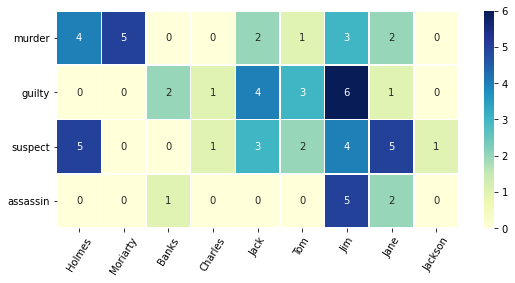

In [8]:
def visualize_co_occurrence(data, keywords_rows, closeness_words_columns):

    #create a dataframe from the provided data
    df = pandas.DataFrame(data, index=keywords_rows, columns=closeness_words_columns)

    #set plot size according to the number of cols and rows
    plt.figure(figsize=(len(columns_example),len(rows_example)))

    #set color of heatmap
    heatmap = sns.heatmap(df, cmap="YlGnBu", annot=True, linewidths=.5)

    #rotate text
    loc_x, labels_x = plt.xticks()
    loc_y, labels_y = plt.yticks()
    heatmap.set_xticklabels(labels_x, rotation=58)
    heatmap.set_yticklabels(labels_y, rotation=0)
    

#example
rows_example = ["murder", "guilty","suspect","assassin"]
columns_example = ["Holmes", "Moriarty","Banks","Charles","Jack","Tom","Jim","Jane","Jackson"]
data_example = [[4,5,0,0,2,1,3,2,0],[0,0,2,1,4,3,6,1,0],[5,0,0,1,3,2,4,5,1],[0,0,1,0,0,0,5,2,0]]

#call method
visualize_co_occurrence(data_example,rows_example,columns_example)


In [33]:
'''def histogram_words(data, labels):
    
    #create a dataframe from the provided data
    df = pandas.DataFrame(data, index=labels, columns=["count"])
    print(df)
    #ax = sns.countplot(x="count", data=df)
    sns.barplot(df, x="count", y=labels)


labels_example = ["murder", "guilty","suspect","assassin"]
data_example = [5,8,3,1]
histogram_words(data_example,labels_example)...

SyntaxError: ignored

     survived  pclass     sex   age  ...  deck  embark_town  alive  alone
0           0       3    male  22.0  ...   NaN  Southampton     no  False
1           1       1  female  38.0  ...     C    Cherbourg    yes  False
2           1       3  female  26.0  ...   NaN  Southampton    yes   True
3           1       1  female  35.0  ...     C  Southampton    yes  False
4           0       3    male  35.0  ...   NaN  Southampton     no   True
..        ...     ...     ...   ...  ...   ...          ...    ...    ...
886         0       2    male  27.0  ...   NaN  Southampton     no   True
887         1       1  female  19.0  ...     B  Southampton    yes   True
888         0       3  female   NaN  ...   NaN  Southampton     no  False
889         1       1    male  26.0  ...     C    Cherbourg    yes   True
890         0       3    male  32.0  ...   NaN   Queenstown     no   True

[891 rows x 15 columns]


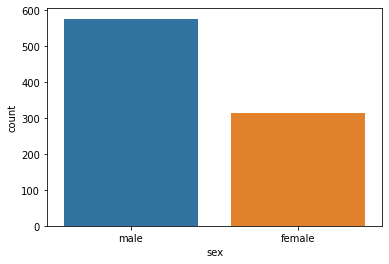

In [12]:
'''import seaborn as sns

titanic = sns.load_dataset("titanic")
print(titanic)
ax = sns.countplot(x="sex", data=titanic)'''